Here, we try running the trajectory analysis on a [Diffusion Map](https://doi.org/10.1093/bioinformatics/btv325) embedding rather than a UMAP embedding of the data

In [1]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    library(monocle3, quietly = T)
    library(SeuratWrappers, quietly = T)
    
    library(ggplot2, quietly = T)
    library(cowplot, quietly = T)
    
    library(dplyr, quietly = T)
    
    library(destiny)
})

In [2]:
server = 'mando'
if (server == 'jabba'){
    data_path = '/data3/hratch/norcross_abc/'
}else if (server == 'mando'){
    data_path = '/data/hratch/norcross_abc/'
}

Associated tutorials:

1) https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/
2) http://htmlpreview.github.io/?https://github.com/satijalab/seurat-wrappers/blob/master/docs/monocle3.html
3) https://stuartlab.org/signac/articles/monocle.html

In [3]:
# Load and format T cell data to get just the CD8s

In [4]:
abc.tcells<-readRDS(paste0(data_path, 'processed/abc_tcells.RDS'))
Idents(abc.tcells)<-'Cell.Type.Level2'

Subset to just the CD8+ T cells

In [5]:
abc.cd8s.all<-abc.tcells[, unname(sapply(as.character(abc.tcells$Cell.Type.Level2), function(x) startsWith(x, 'CD8+')))]

Run diffusion map on number of PCs determined in [Transformation notebook](./01_process_data/01A_Transform.ipynb):

In [24]:
n_pcs<-44
abc.cds.all.sc<-Seurat::as.SingleCellExperiment(abc.cd8s.all)

# filter for n_pcs
reducedDims(abc.cds.all.sc)[['PCA']]<-reducedDims(abc.cds.all.sc)[['PCA']][, 1:n_pcs]
reducedDims(abc.cds.all.sc)[['pca']]<-reducedDims(abc.cds.all.sc)[['PCA']]

dm <- destiny::DiffusionMap(data = abc.cds.all.sc, 
                     n_pcs = n_pcs) # uses PCs in abc.cds.all by default

abc.cd8s.all[['DiffusionMap']] <-  CreateDimReducObject(embeddings = dm@eigenvectors, 
                                                        key = "DM_", 
                                                        assay = DefaultAssay(abc.cd8s.all))

In [ ]:
dr <- CreateDimReducObject(embeddings = dm@eigenvectors, key = 'DiffusionMap')
seurat.object[['DiffusionMap']] <- dr
DimPlot(object = seurat.object, reduction = "DiffusionMap") + coord_fixed(ratio = 1)

Unlike in UMAP space, the distince naive T-cell clusters 30, 41 and 43 all group together in DiffusionMap space. Thus, we do not need to worry about setting the root node based on just one of the clusters:

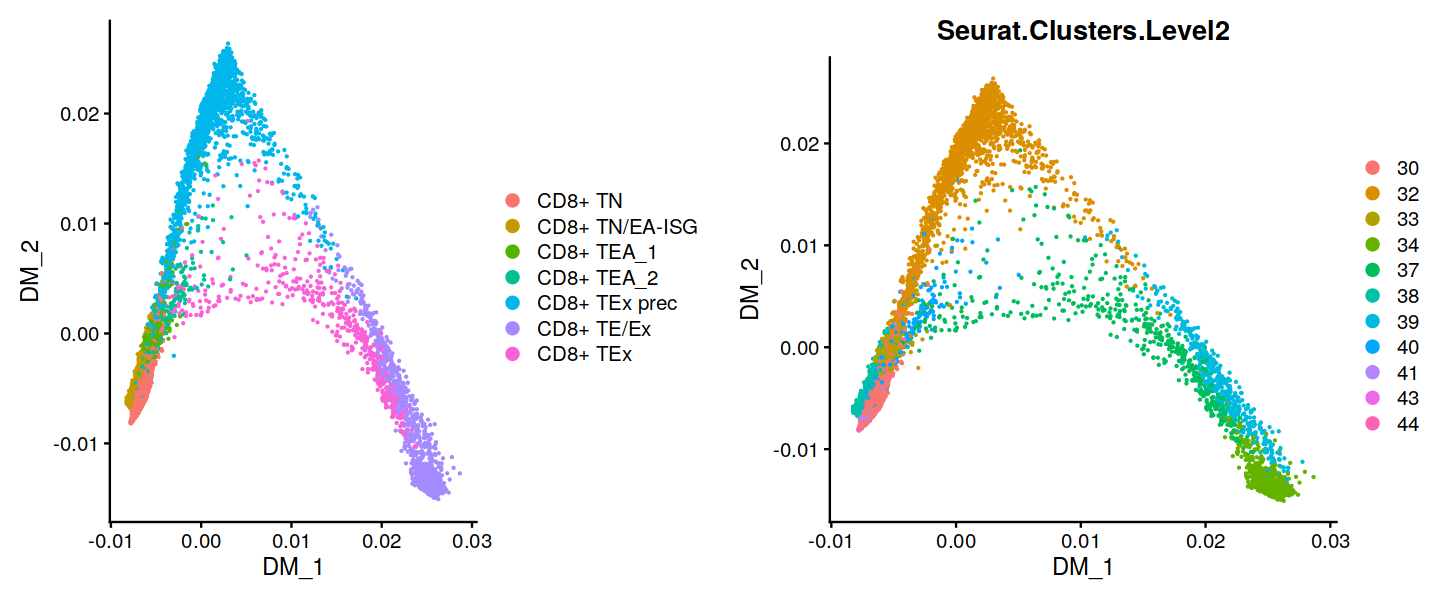

In [44]:
h_ = 5
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

g1A<-DimPlot(abc.cd8s.all, reduction = 'DiffusionMap', shuffle = T)
g1B<-DimPlot(abc.cd8s.all, reduction = 'DiffusionMap', group.by = 'Seurat.Clusters.Level2', shuffle = T)
g1<-cowplot::plot_grid(g1A, g1B, ncol = 2)
g1

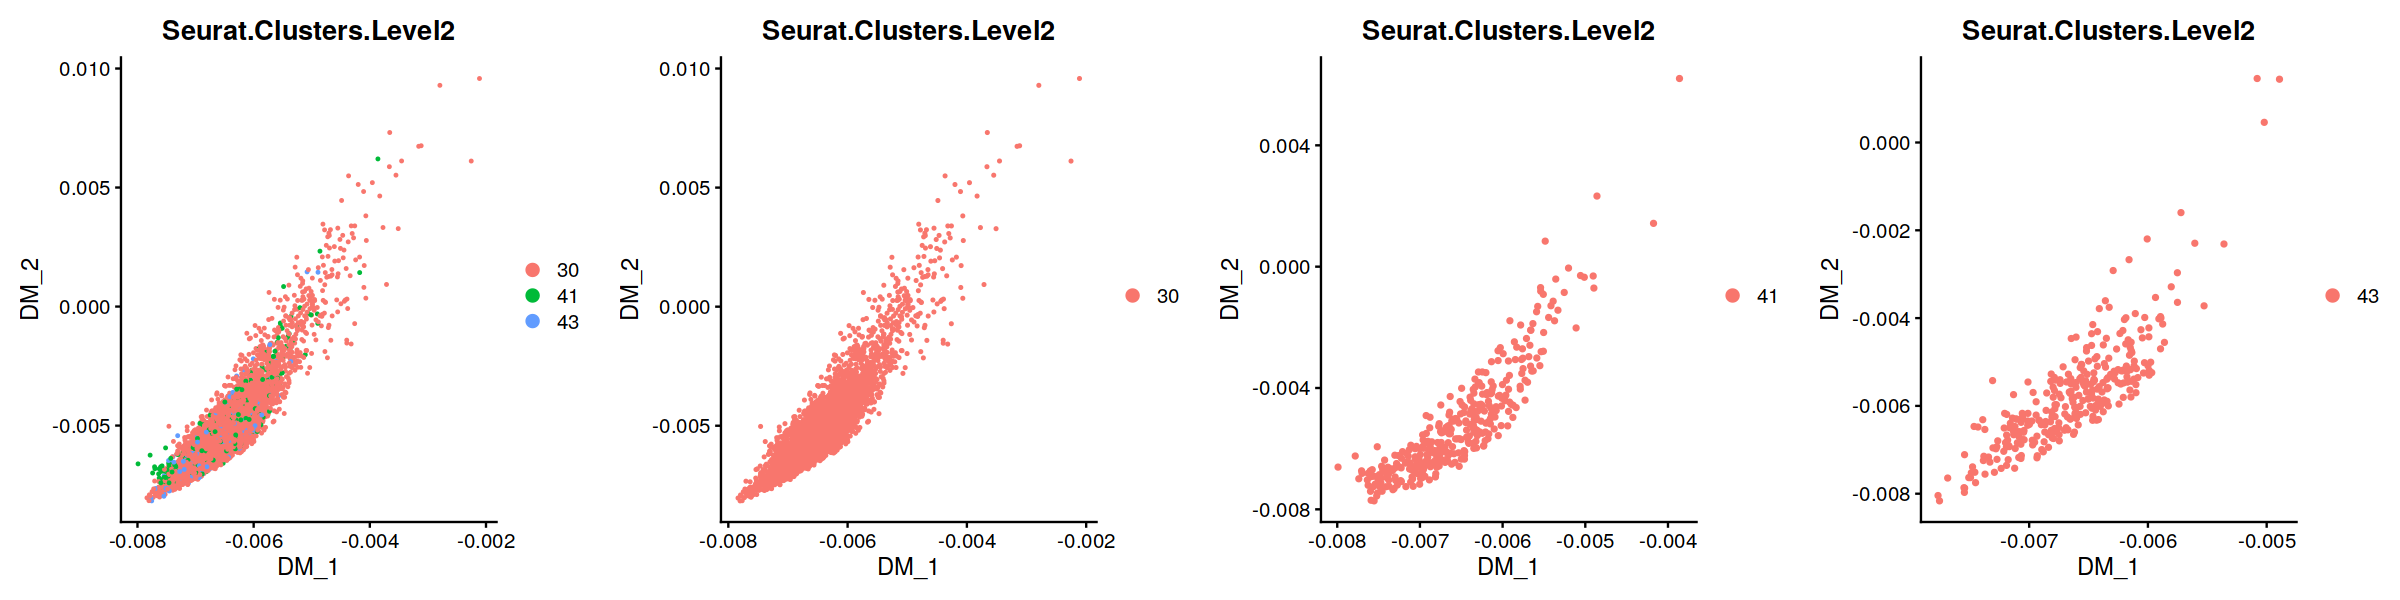

In [51]:
naives.only<-subset(abc.cd8s.all, subset = Seurat.Clusters.Level2 %in% c('30', '41', '43'))

h_ = 5
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g1A<-DimPlot(naives.only, reduction = 'DiffusionMap', shuffle = T)
g1B<-DimPlot(naives.only, reduction = 'DiffusionMap', group.by = 'Seurat.Clusters.Level2', shuffle = T)

g1C<-DimPlot(subset(naives.only, subset = Seurat.Clusters.Level2 == ('30')), 
             reduction = 'DiffusionMap', group.by = 'Seurat.Clusters.Level2', shuffle = T)
g1D<-DimPlot(subset(naives.only, subset = Seurat.Clusters.Level2 == ('41')), 
             reduction = 'DiffusionMap', group.by = 'Seurat.Clusters.Level2', shuffle = T)
g1E<-DimPlot(subset(naives.only, subset = Seurat.Clusters.Level2 == ('43')), 
             reduction = 'DiffusionMap', group.by = 'Seurat.Clusters.Level2', shuffle = T)

g1<-cowplot::plot_grid(g1B, g1C, g1D, g1E, ncol = 4)
g1

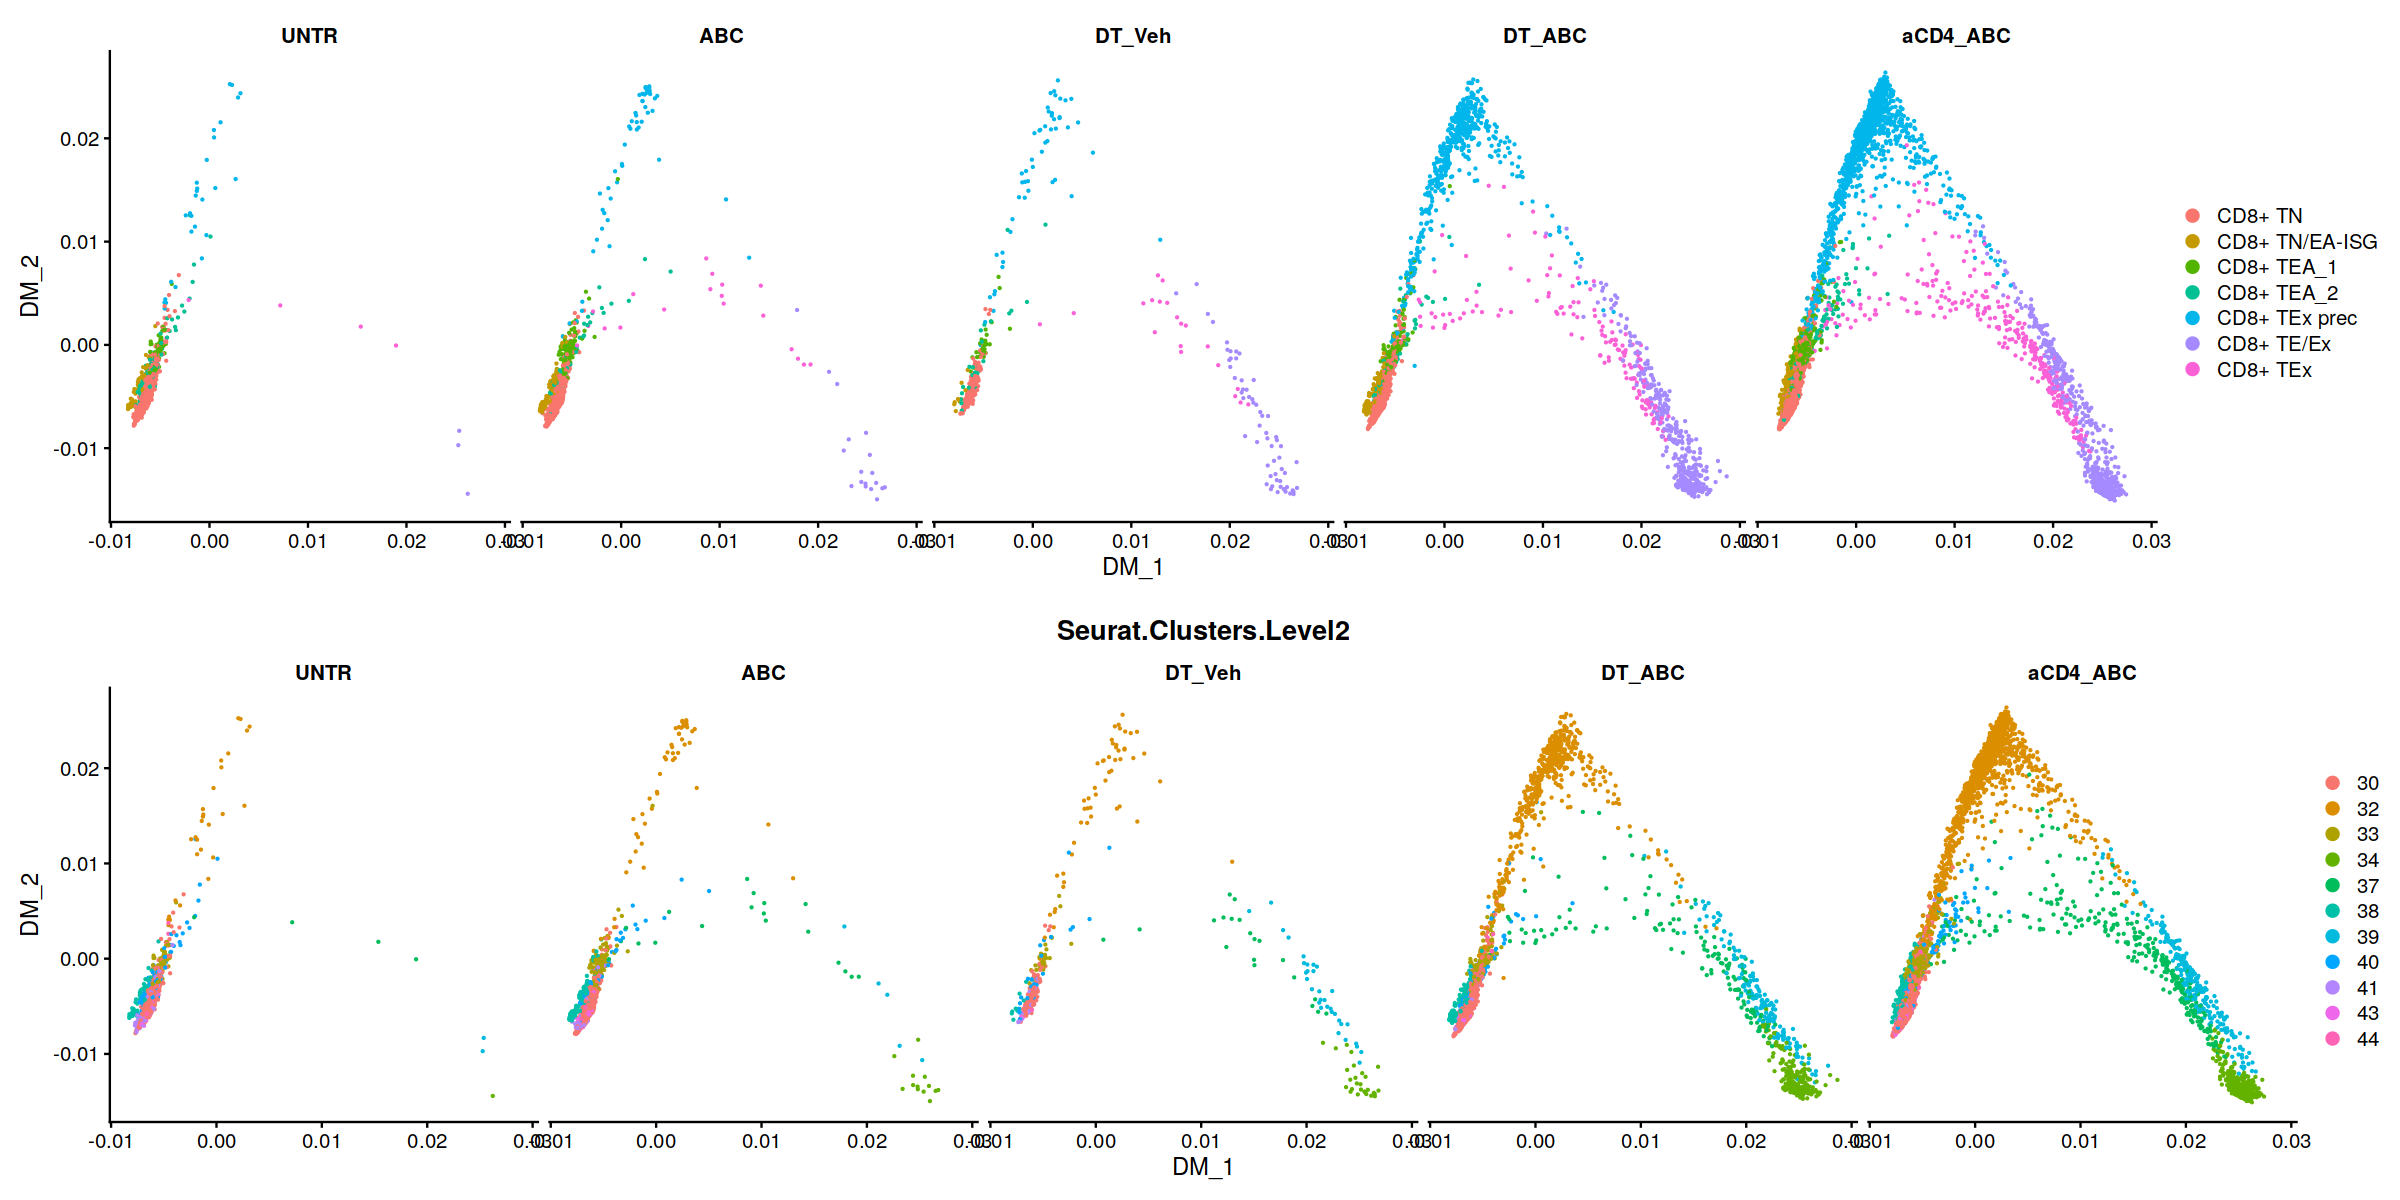

In [52]:
h_ = 10
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g2A<-DimPlot(abc.cd8s.all, reduction = 'DiffusionMap', split.by = 'orig.ident')
g2B<-DimPlot(abc.cd8s.all, reduction = 'DiffusionMap', group.by = 'Seurat.Clusters.Level2', split.by = 'orig.ident')
g2<-cowplot::plot_grid(g2A, g2B, ncol = 1)
g2

In [53]:
md<-abc.cd8s.all@meta.data

md[['Root.Node']]<-'no'
md[(md$Cell.Type.Level2 == 'CD8+ TN'), 'Root.Node']<-'yes'
# md[(md$Cell.Type.Level2 == 'CD8+ TN') & (md$Seurat.Clusters.Level2 != '44'), 'Root.Node']<-'yes'
abc.cd8s.all@meta.data<-md

In [113]:
# a helper function to identify the root principal points:
get_earliest_principal_node <- function(cds, root.node="yes", dr = 'DIFFUSIONMAP'){
  cell_ids <- which(colData(cds)[, "Root.Node"] == root.node)
  
  closest_vertex <-
  cds@principal_graph_aux[[dr]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
  igraph::V(principal_graph(cds)[[dr]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}

Modify Monocle functions to work with DiffusionMap:

In [86]:
cluster_cells_ <- function(cds,
                          reduction_method = c("UMAP", "tSNE", "PCA", "LSI", "Aligned", 'DIFFUSIONMAP'),
                          k = 20,
                          cluster_method = c('leiden', 'louvain'),
                          num_iter = 2,
                          partition_qval = 0.05,
                          weight = FALSE,
                          resolution = NULL,
                          random_seed = 42,
                          verbose = FALSE,
                          nn_control = list(),
                          ...) {
  assertthat::assert_that(
    tryCatch(expr = ifelse(match.arg(reduction_method) == "",TRUE, TRUE),
             error = function(e) FALSE),
    msg = "reduction_method must be one of 'UMAP', 'tSNE', 'PCA', 'LSI', 'Aligned', 'DIFFUSIONMAP'")
  reduction_method <- match.arg(reduction_method)

  assertthat::assert_that(
    tryCatch(expr = ifelse(match.arg(cluster_method) == "",TRUE, TRUE),
             error = function(e) FALSE),
    msg = "cluster_method must be one of 'leiden', 'louvain'")
  cluster_method <- match.arg(cluster_method)

  assertthat::assert_that(methods::is(cds, "cell_data_set"))
  assertthat::assert_that(is.character(reduction_method))
  assertthat::assert_that(is.logical(weight))
  assertthat::assert_that(assertthat::is.count(num_iter))
  assertthat::assert_that(assertthat::is.count(k))
  assertthat::assert_that(!is.null(colnames(cds)),
                          msg=message('cluster_cells: the cds is missing cell names, which are required by cluster_cells.'))

  if (!is.null(resolution) & cluster_method == "louvain") {
    message("Resolution can only be used when cluster_method is ",
                  "'leiden'. Switching to leiden clustering.")
    cluster_method <- "leiden"
  }

  if(!is.null(resolution)) {
    assertthat::assert_that(is.numeric(resolution))
  }
  assertthat::assert_that(is.numeric(partition_qval))
  assertthat::assert_that(is.logical(verbose))
  assertthat::assert_that(!is.null(SingleCellExperiment::reducedDims(cds)[[reduction_method]]),
                          msg = paste("No dimensionality reduction for",
                                      reduction_method, "calculated.",
                                      "Please run reduce_dimension with",
                                      "reduction_method =", reduction_method,
                                      "before running cluster_cells"))

  if(reduction_method == 'tSNE' || reduction_method == 'UMAP')
    nn_control_default <- monocle3:::get_global_variable('nn_control_annoy_euclidean')
  else
    nn_control_default <- monocle3:::get_global_variable('nn_control_annoy_cosine')

  nn_control <- monocle3:::set_nn_control(mode=3,
                               nn_control=nn_control,
                               nn_control_default=nn_control_default,
                               nn_index=NULL,
                               k=k,
                               verbose=verbose)
  nn_method <- nn_control[['method']]

  # The nn index is made on the full SingleCellExperiment::reducedDims(cds)[[reduction_method]]
  # matrix so use/store the nn index object in the cds. This saves nn index
  # build time if the index is used later in another function. In that case,
  # test for nn index consistency.
  # Later note: the cds may be subsetted in which case the index will be
  #             invalid and I don't know how to check for a subsetted
  #             or otherwise modified cds so I comment out the following
  #             code that tries to use an existing index.
# Check for consistency between matrix and index before
# using the following code.
#   if((nn_method == 'annoy' || nn_method == 'hnsw')) {
#      if(!check_cds_nn_index_is_current(cds=cds, reduction_method=reduction_method, nn_control=nn_control, verbose=verbose)) {
#        nn_index <- make_nn_index(subject_matrix=SingleCellExperiment::reducedDims(cds)[[reduction_method]],
#                                  nn_control=nn_control,
#                                  verbose=verbose)
#        cds <- set_cds_nn_index(cds=cds,
#                                reduction_method=reduction_method,
#                                nn_index=nn_index,
#                                verbose=verbose)
#      }
#      else {
#        nn_index <- get_cds_nn_index(cds=cds,
#                                     reduction_method=reduction_method,
#                                     nn_method=nn_method,
#                                     verbose=verbose)
#      }
#   }
#   else
#   if(nn_method == 'nn2') {
#     nn_index <- NULL
#   }

  # Set nn_index to NULL so that louvain_clustering and
  # monocle3:::leiden_clustering make a new index.
  nn_index <- NULL

  reduced_dim_res <- SingleCellExperiment::reducedDims(cds)[[reduction_method]]

  if(is.null(random_seed)) {
    random_seed <- sample.int(.Machine$integer.max, 1)
  }
  if(verbose)
    message("Running ", cluster_method, " clustering algorithm ...")

  if(cluster_method=='louvain') {
    cluster_result <- louvain_clustering(data=reduced_dim_res,
                                         pd=colData(cds),
                                         weight=weight,
                                         nn_index=nn_index,
                                         k=k,
                                         nn_control=nn_control,
                                         louvain_iter=num_iter,
                                         random_seed=random_seed,
                                         verbose=verbose)

    if (length(unique(cluster_result$optim_res$membership)) > 1) {
      cluster_graph_res <- monocle3:::compute_partitions(cluster_result$g,
                                              cluster_result$optim_res,
                                              partition_qval, verbose)
      partitions <- igraph::components(
        cluster_graph_res$cluster_g)$membership[cluster_result$optim_res$membership]
      partitions <- as.factor(partitions)
    } else {
      partitions <- rep(1, nrow(colData(cds)))
    }
    names(partitions) <- row.names(reduced_dim_res)
    clusters <- factor(igraph::membership(cluster_result$optim_res))
    cds@clusters[[reduction_method]] <- list(cluster_result = cluster_result,
                                             partitions = partitions,
                                             clusters = clusters)
  }
  else if(cluster_method=='leiden'){
    cds <- monocle3:::add_citation(cds, "leiden")
    cluster_result <- monocle3:::leiden_clustering(data=reduced_dim_res,
                                        pd=colData(cds),
                                        weight=weight,
                                        nn_index=nn_index,
                                        k=k,
                                        nn_control=nn_control,
                                        num_iter=num_iter,
                                        resolution_parameter=resolution,
                                        random_seed=random_seed,
                                        verbose=verbose, ...)

    if(length(unique(cluster_result$optim_res$membership)) > 1) {
      cluster_graph_res <- monocle3:::compute_partitions(cluster_result$g,
                                              cluster_result$optim_res,
                                              partition_qval, verbose)
      partitions <- igraph::components(
        cluster_graph_res$cluster_g)$membership[cluster_result$optim_res$membership]
      partitions <- as.factor(partitions)
    } else {
      partitions <- rep(1, nrow(colData(cds)))
    }
    names(partitions) <- row.names(reduced_dim_res)
    clusters <- factor(igraph::membership(cluster_result$optim_res))
    cds@clusters[[reduction_method]] <- list(cluster_result = cluster_result,
                                             partitions = partitions,
                                             clusters = clusters)
  }
  cds <- monocle3:::add_citation(cds, "clusters")
  cds <- monocle3:::add_citation(cds, "partitions")
  return(cds)
}

In [99]:
project_point_to_line_segment<-monocle3:::project_point_to_line_segment

learn_graph_ <- function(cds,
                        use_partition = TRUE,
                        close_loop = TRUE,
                        learn_graph_control = NULL,
                        verbose = FALSE, 
                       reduction_method = 'DIFFUSIONMAP') {

#   reduction_method <- "UMAP"
  if (!is.null(learn_graph_control)) {
    assertthat::assert_that(methods::is(learn_graph_control, "list"))
    assertthat::assert_that(all(names(learn_graph_control) %in%
                                  c("euclidean_distance_ratio",
                                    "geodesic_distance_ratio",
                                    "minimal_branch_len",
                                    "orthogonal_proj_tip",
                                    "prune_graph",
                                    "scale",
                                    "ncenter",
                                    "nn.k",
                                    "rann.k",
                                    "maxiter",
                                    "eps",
                                    "L1.gamma",
                                    "L1.sigma",
                                    "nn.method",
                                    "nn.metric",
                                    "nn.n_trees",
                                    "nn.search_k",
                                    "nn.M",
                                    "nn.ef_construction",
                                    "nn.ef",
                                    "nn.grain_size",
                                    "nn.cores")),
                            msg = "Unknown variable in learn_graph_control")
  }

  if(!is.null(learn_graph_control[['rann.k']]) && !is.null(learn_graph_control[['nn.k']])) {
    assertthat::assert_that(learn_graph_control[['rann.k']] == learn_graph_control[['nn.k']],
                            msg=paste0('both learn_graph_control$nn.k and learn_graph_control$rann.k are',
                                       ' defined and are unequal. See help(learn_graph) for more',
                                       ' information.'))
  }

  if(is.null(learn_graph_control[['nn.k']]) && !is.null(learn_graph_control[['rann.k']]))
    learn_graph_control[['nn.k']] <- learn_graph_control[['rann.k']]

  euclidean_distance_ratio <-
    ifelse(is.null(learn_graph_control$euclidean_distance_ratio), 1,
           learn_graph_control$euclidean_distance_ratio)
  geodesic_distance_ratio <-
    ifelse(is.null(learn_graph_control$geodesic_distance_ratio), 1/3,
           learn_graph_control$geodesic_distance_ratio)
  minimal_branch_len <-
    ifelse(is.null(learn_graph_control$minimal_branch_len), 10,
           learn_graph_control$minimal_branch_len)
  orthogonal_proj_tip <-
    ifelse(is.null(learn_graph_control$orthogonal_proj_tip), FALSE,
           learn_graph_control$orthogonal_proj_tip)
  prune_graph <- ifelse(is.null(learn_graph_control$prune_graph), TRUE,
                        learn_graph_control$prune_graph)
  ncenter <- learn_graph_control$ncenter
  scale <- ifelse(is.null(learn_graph_control$scale), FALSE,
                  learn_graph_control$scale)
  nn.k <- ifelse(is.null(learn_graph_control[['nn.k']]), 25,
                   learn_graph_control[['nn.k']])
  maxiter <- ifelse(is.null(learn_graph_control$maxiter), 10,
                    learn_graph_control$maxiter)
  eps <- ifelse(is.null(learn_graph_control$eps), 1e-5,
                learn_graph_control$eps)
  L1.gamma <- ifelse(is.null(learn_graph_control$L1.gamma), 0.5,
                     learn_graph_control$L1.gamma)
  L1.sigma <- ifelse(is.null(learn_graph_control$L1.sigma), 0.01,
                     learn_graph_control$L1.sigma)

  assertthat::assert_that(methods::is(cds, "cell_data_set"))
  assertthat::assert_that(reduction_method %in% c('UMAP', 'DIFFUSIONMAP'), msg=paste0('unsupported or invalid reduction method \'', reduction_method, '\''))
  assertthat::assert_that(is.logical(use_partition))
  assertthat::assert_that(is.logical(close_loop))
  assertthat::assert_that(is.logical(verbose))
  assertthat::assert_that(is.logical(orthogonal_proj_tip))
  assertthat::assert_that(is.logical(prune_graph))
  assertthat::assert_that(is.logical(scale))
  assertthat::assert_that(is.numeric(euclidean_distance_ratio))
  assertthat::assert_that(is.numeric(geodesic_distance_ratio))
  assertthat::assert_that(is.numeric(minimal_branch_len))
  if(!is.null(ncenter)) {
    assertthat::assert_that(assertthat::is.count(ncenter))
  }
  assertthat::assert_that(assertthat::is.count(maxiter))
  assertthat::assert_that(assertthat::is.count(nn.k))
  assertthat::assert_that(is.numeric(eps))
  assertthat::assert_that(is.numeric(L1.sigma))
  assertthat::assert_that(is.numeric(L1.sigma))

  assertthat::assert_that(!is.null(SingleCellExperiment::reducedDims(cds)[[reduction_method]]),
                          msg = paste("No dimensionality reduction for",
                                      reduction_method, "calculated.",
                                      "Please run reduce_dimension with",
                                      "reduction_method =", reduction_method,
                                      "and cluster_cells before running",
                                      "learn_graph."))
  assertthat::assert_that(!is.null(cds@clusters[[reduction_method]]),
                          msg = paste("No cell clusters for",
                                      reduction_method, "calculated.",
                                      "Please run cluster_cells with",
                                      "reduction_method =", reduction_method,
                                      "before running learn_graph."))

  nn_control <- list()
  if(!is.null(learn_graph_control[['nn.method']])) nn_control[['method']] <- learn_graph_control[['nn.method']]
  if(!is.null(learn_graph_control[['nn.metric']])) nn_control[['metric']] <- learn_graph_control[['nn.metric']]
  if(!is.null(learn_graph_control[['nn.n_trees']])) nn_control[['n_trees']] <- learn_graph_control[['nn.n_trees']]
  if(!is.null(learn_graph_control[['nn.search_k']])) nn_control[['search_k']] <- learn_graph_control[['nn.search_k']]
  if(!is.null(learn_graph_control[['nn.M']])) nn_control[['M']] <- learn_graph_control[['nn.M']]
  if(!is.null(learn_graph_control[['nn.ef_construction']])) nn_control[['ef_construction']] <- learn_graph_control[['nn.ef_construction']]
  if(!is.null(learn_graph_control[['nn.ef']])) nn_control[['ef']] <- learn_graph_control[['nn.ef']]
  if(!is.null(learn_graph_control[['nn.grain_size']])) nn_control[['grain_size']] <- learn_graph_control[['nn.grain_size']]
  if(!is.null(learn_graph_control[['nn.cores']])) nn_control[['cores']] <- learn_graph_control[['nn.cores']]

  if(verbose)
    report_nn_control('nn_control: ', nn_control)

  nn_control_default <- monocle3::: get_global_variable('nn_control_annoy_euclidean')
  nn_control <- monocle3::: set_nn_control(mode=3,
                               nn_control=nn_control,
                               nn_control_default=nn_control_default,
                               nn_index=NULL,
                               k=nn.k,
                               verbose=verbose)

  if (use_partition) {
    partition_list <- cds@clusters[[reduction_method]]$partitions
  } else {
    partition_list <- rep(1, nrow(colData(cds)))
  }

  multi_tree_DDRTree_res <-
    monocle3:::multi_component_RGE(cds, scale = scale,
                        reduction_method = reduction_method,
                        partition_list = partition_list,
                        irlba_pca_res = SingleCellExperiment::reducedDims(cds)[[reduction_method]],
                        max_components = max_components,
                        ncenter = ncenter,
                        nn.k = nn.k,
                        nn_control = nn_control,
                        maxiter = maxiter,
                        eps = eps,
                        L1.gamma = L1.gamma,
                        L1.sigma = L1.sigma,
                        close_loop = close_loop,
                        euclidean_distance_ratio = euclidean_distance_ratio,
                        geodesic_distance_ratio = geodesic_distance_ratio,
                        prune_graph = prune_graph,
                        minimal_branch_len = minimal_branch_len,
                        verbose = verbose)

  rge_res_W <- multi_tree_DDRTree_res$ddrtree_res_W
  rge_res_Z <- multi_tree_DDRTree_res$ddrtree_res_Z
  rge_res_Y <- multi_tree_DDRTree_res$ddrtree_res_Y
  cds <- multi_tree_DDRTree_res$cds
  dp_mst <- multi_tree_DDRTree_res$dp_mst


  principal_graph(cds)[[reduction_method]] <- dp_mst
  cds@principal_graph_aux[[reduction_method]]$dp_mst <- rge_res_Y

  cds <- monocle3:::project2MST(cds, project_point_to_line_segment, orthogonal_proj_tip,
                     verbose, reduction_method, rge_res_Y)

  cds
}

In [116]:
order_cells_ <- function(cds,
                        reduction_method = "DIFFUSIONMAP",
                        root_pr_nodes=NULL,
                        root_cells=NULL,
                        verbose = FALSE){

  assertthat::assert_that(methods::is(cds, "cell_data_set"))
#   assertthat::assert_that(assertthat::are_equal("UMAP", reduction_method),
#                           msg = paste("Currently only 'UMAP' is accepted as a",
#                                       "reduction_method."))
  assertthat::assert_that(!is.null(SingleCellExperiment::reducedDims(cds)[[reduction_method]]),
                          msg = paste0("No dimensionality reduction for ",
                                      reduction_method, " calculated. ",
                                      "Please run reduce_dimension with ",
                                      "reduction_method = ", reduction_method,
                                      ", cluster_cells, and learn_graph ",
                                      "before running order_cells."))
  assertthat::assert_that(!is.null(cds@clusters[[reduction_method]]),
                          msg = paste("No cell clusters for",
                                      reduction_method, "calculated.",
                                      "Please run cluster_cells with",
                                      "reduction_method =", reduction_method,
                                      "and run learn_graph before running",
                                      "order_cells."))
  assertthat::assert_that(!is.null(principal_graph(cds)[[reduction_method]]),
                          msg = paste("No principal graph for",
                                      reduction_method, "calculated.",
                                      "Please run learn_graph with",
                                      "reduction_method =", reduction_method,
                                      "before running order_cells."))
  assertthat::assert_that(
    igraph::vcount(principal_graph(cds)[[reduction_method]]) < 10000,
    msg = paste("principal graph is too large. order_cells doesn't support",
                "more than 10 thousand centroids."))
  if(!is.null(root_pr_nodes)) {
    assertthat::assert_that(
      all(root_pr_nodes %in%
            igraph::V(principal_graph(cds)[[reduction_method]])$name),
      msg = paste("All provided root_pr_nodes must be present in the",
                  "principal graph."))
  }

  if(!is.null(root_cells)) {
    assertthat::assert_that(all(root_cells %in% row.names(colData(cds))),
                            msg = paste("All provided root_cells must be",
                                        "present in the cell data set."))
  }

  if(is.null(root_cells) & is.null(root_pr_nodes)) {
    assertthat::assert_that(interactive(),
                            msg = paste("When not in interactive mode, either",
                                        "root_pr_nodes or root_cells",
                                        "must be provided."))
  }
  assertthat::assert_that(!all(c(!is.null(root_cells),
                                 !is.null(root_pr_nodes))),
                          msg = paste("Please specify either root_pr_nodes",
                                      "or root_cells, not both."))

  if (is.null(root_pr_nodes) & is.null(root_cells)){
    if (interactive()){
      root_pr_nodes <-
        select_trajectory_roots(cds, reduction_method = reduction_method)
      if(length(root_pr_nodes) == 0) {
        stop("No root node was chosen!")
      }
    }
  } else if(!is.null(root_cells)){
    closest_vertex <- cds@principal_graph_aux[[
      reduction_method]]$pr_graph_cell_proj_closest_vertex
    root_pr_nodes <- unique(paste("Y_", closest_vertex[root_cells,], sep=""))
    #principal_graph(cds)[[reduction_method]]
  }

  cds@principal_graph_aux[[reduction_method]]$root_pr_nodes <- root_pr_nodes

  cc_ordering <- monocle3:::extract_general_graph_ordering(cds, root_pr_nodes, verbose,
                                                reduction_method)
  cds@principal_graph_aux[[reduction_method]]$pseudotime <-
    cc_ordering[row.names(colData(cds)), ]$pseudo_time
  names(cds@principal_graph_aux[[reduction_method]]$pseudotime) <-
    row.names(colData(cds))

  cds
}

In [136]:
plot_cells_ <- function(cds,
                       x=1,
                       y=2,
                       reduction_method = c("UMAP", "tSNE", "PCA", "LSI", "Aligned", 'DIFFUSIONMAP'),
                       color_cells_by="cluster",
                       group_cells_by=c("cluster", "partition"),
                       genes=NULL,
                       show_trajectory_graph=TRUE,
                       trajectory_graph_color="grey28",
                       trajectory_graph_segment_size=0.75,
                       norm_method = c("log", "size_only"),
                       label_cell_groups = TRUE,
                       label_groups_by_cluster=TRUE,
                       group_label_size=2,
                       labels_per_group=1,
                       label_branch_points=TRUE,
                       label_roots=TRUE,
                       label_leaves=TRUE,
                       graph_label_size=2,
                       cell_size=0.35,
                       cell_stroke= I(cell_size / 2),
                       alpha = 1,
                       min_expr=0.1,
                       rasterize=FALSE,
                       scale_to_range=TRUE,
                       label_principal_points = FALSE) {
  feature_label <- min_val_for_feature <- max_val_for_feature <- NULL # no visible binding
  cell_group <- cell_color <- cells_in_cluster <- per <- NULL # no visible binding
  reduction_method <- match.arg(reduction_method)
  assertthat::assert_that(methods::is(cds, "cell_data_set"))
  assertthat::assert_that(!is.null(SingleCellExperiment::reducedDims(cds)[[reduction_method]]),
                          msg = paste("No dimensionality reduction for",
                                      reduction_method, "calculated.",
                                      "Please run reduce_dimension with",
                                      "reduction_method =", reduction_method,
                                      "before attempting to plot."))
  low_dim_coords <- SingleCellExperiment::reducedDims(cds)[[reduction_method]]
  assertthat::assert_that(ncol(low_dim_coords) >=max(x,y),
                          msg = paste("x and/or y is too large. x and y must",
                                      "be dimensions in reduced dimension",
                                      "space."))
  if(!is.null(color_cells_by)) {
    assertthat::assert_that(color_cells_by %in% c("cluster", "partition",
                                                  "pseudotime") |
                              color_cells_by %in% names(colData(cds)),
                            msg = paste("color_cells_by must one of",
                                        "'cluster', 'partition', 'pseudotime,",
                                        "or a column in the colData table."))

    if(color_cells_by == "pseudotime") {
      tryCatch({pseudotime(cds, reduction_method = reduction_method)},
               error = function(x) {
                 stop("No pseudotime for ", reduction_method,
                            " calculated. Please run order_cells with ",
                            "reduction_method = ", reduction_method,
                            " before attempting to color by pseudotime.")})

    }
  }
  assertthat::assert_that(!is.null(color_cells_by) || !is.null(markers),
                          msg = paste("Either color_cells_by or markers must",
                                      "be NULL, cannot color by both!"))

  norm_method = match.arg(norm_method)
  group_cells_by=match.arg(group_cells_by)
  assertthat::assert_that(!is.null(color_cells_by) || !is.null(genes),
                          msg = paste("Either color_cells_by or genes must be",
                                      "NULL, cannot color by both!"))

  if (show_trajectory_graph &&
      is.null(principal_graph(cds)[[reduction_method]])) {
    message("No trajectory to plot. Has learn_graph() been called yet?")
    show_trajectory_graph = FALSE
  }
  if (label_principal_points &&
      is.null(principal_graph(cds)[[reduction_method]])) {
    message("Cannot label principal points when no trajectory to plot. Has learn_graph() been called yet?")
    label_principal_points = FALSE
  }

  if (label_principal_points) {
    label_branch_points <- FALSE
    label_leaves <- FALSE
    label_roots <- FALSE
  }



  gene_short_name <- NA
  sample_name <- NA
  #sample_state <- colData(cds)$State
  data_dim_1 <- NA
  data_dim_2 <- NA
  if (rasterize){
    plotting_func <- ggrastr::geom_point_rast
  }else{
    plotting_func <- ggplot2::geom_point
  }

  S_matrix <- SingleCellExperiment::reducedDims(cds)[[reduction_method]]
  data_df <- data.frame(S_matrix[,c(x,y)])

  colnames(data_df) <- c("data_dim_1", "data_dim_2")
  data_df$sample_name <- row.names(data_df)

  data_df <- as.data.frame(cbind(data_df, colData(cds)))
  if (group_cells_by == "cluster"){
    data_df$cell_group <-
      tryCatch({clusters(cds,
                         reduction_method = reduction_method)[
                           data_df$sample_name]},
               error = function(e) {NULL})
  } else if (group_cells_by == "partition") {
    data_df$cell_group <-
      tryCatch({partitions(cds,
                           reduction_method = reduction_method)[
                             data_df$sample_name]},
               error = function(e) {NULL})
  } else{
    stop("Unrecognized way of grouping cells.")
  }

  if (color_cells_by == "cluster"){
    data_df$cell_color <-
      tryCatch({clusters(cds,
                         reduction_method = reduction_method)[
                           data_df$sample_name]},
               error = function(e) {NULL})
  } else if (color_cells_by == "partition") {
    data_df$cell_color <-
      tryCatch({partitions(cds,
                           reduction_method = reduction_method)[
                             data_df$sample_name]},
               error = function(e) {NULL})
  } else if (color_cells_by == "pseudotime") {
    data_df$cell_color <-
      tryCatch({pseudotime(cds,
                           reduction_method = reduction_method)[
                             data_df$sample_name]}, error = function(e) {NULL})
  } else{
    data_df$cell_color <- colData(cds)[data_df$sample_name,color_cells_by]
  }

  ## Graph info
  if (show_trajectory_graph) {

    ica_space_df <- t(cds@principal_graph_aux[[reduction_method]]$dp_mst) %>%
      as.data.frame() %>%
      dplyr::select(prin_graph_dim_1 = x, prin_graph_dim_2 = y) %>%
      dplyr::mutate(sample_name = rownames(.),
                    sample_state = rownames(.))

    dp_mst <- cds@principal_graph[[reduction_method]]

    edge_df <- dp_mst %>%
      igraph::as_data_frame() %>%
      dplyr::select(source = "from", target = "to") %>%
      dplyr::left_join(ica_space_df %>%
                         dplyr::select(
                           source="sample_name",
                           source_prin_graph_dim_1="prin_graph_dim_1",
                           source_prin_graph_dim_2="prin_graph_dim_2"),
                       by = "source") %>%
      dplyr::left_join(ica_space_df %>%
                         dplyr::select(
                           target="sample_name",
                           target_prin_graph_dim_1="prin_graph_dim_1",
                           target_prin_graph_dim_2="prin_graph_dim_2"),
                       by = "target")
  }

  ## Marker genes
  markers_exprs <- NULL
  expression_legend_label <- NULL
  if (!is.null(genes)) {
    if (!is.null(dim(genes)) && dim(genes) >= 2){
      markers = unlist(genes[,1], use.names=FALSE)
    } else {
      markers = genes
    }
	markers_rowData <- rowData(cds)[(rowData(cds)$gene_short_name %in% markers) |
							        (row.names(rowData(cds)) %in% markers),,drop=FALSE]
	markers_rowData <- as.data.frame(markers_rowData)
    if (nrow(markers_rowData) == 0) {
      stop("None of the provided genes were found in the cds")
    }
    if (nrow(markers_rowData) >= 1) {
      cds_exprs <- SingleCellExperiment::counts(cds)[row.names(markers_rowData), ,drop=FALSE]
      cds_exprs <- Matrix::t(Matrix::t(cds_exprs)/size_factors(cds))

      if (!is.null(dim(genes)) && dim(genes) >= 2){
        #genes = as.data.frame(genes)
        #row.names(genes) = genes[,1]
        #genes = genes[row.names(cds_exprs),]

        agg_mat = as.matrix(aggregate_gene_expression(cds, genes, norm_method=norm_method, gene_agg_fun="mean", scale_agg_values=FALSE))
        markers_exprs = agg_mat
        markers_exprs <- reshape2::melt(markers_exprs)
        colnames(markers_exprs)[1:2] <- c('feature_id','cell_id')
        if (is.factor(genes[,2]))
          markers_exprs$feature_id = factor(markers_exprs$feature_id,
                                            levels=levels(genes[,2]))

        markers_exprs$feature_label <- markers_exprs$feature_id
        norm_method = "size_only"
        expression_legend_label = "Expression score"
      } else {
        cds_exprs@x = round(10000*cds_exprs@x)/10000
        markers_exprs = matrix(cds_exprs, nrow=nrow(markers_rowData))
        colnames(markers_exprs) = colnames(SingleCellExperiment::counts(cds))
        row.names(markers_exprs) = row.names(markers_rowData)
        markers_exprs <- reshape2::melt(markers_exprs)
        colnames(markers_exprs)[1:2] <- c('feature_id','cell_id')
        markers_exprs <- merge(markers_exprs, markers_rowData,
                               by.x = "feature_id", by.y="row.names")
        if (is.null(markers_exprs$gene_short_name)) {
          markers_exprs$feature_label <-
            as.character(markers_exprs$feature_id)
        } else {
          markers_exprs$feature_label <-
            as.character(markers_exprs$gene_short_name)
        }

        markers_exprs$feature_label <- ifelse(is.na(markers_exprs$feature_label) | !as.character(markers_exprs$feature_label) %in% markers,
                                              as.character(markers_exprs$feature_id),
                                              as.character(markers_exprs$feature_label))

        markers_exprs$feature_label <- factor(markers_exprs$feature_label,
                                              levels = markers)
        if (norm_method == "size_only")
          expression_legend_label = "Expression"
        else
          expression_legend_label = "log10(Expression)"
      }

      if (scale_to_range){
				markers_exprs = dplyr::group_by(markers_exprs, feature_label) %>%
				  dplyr::mutate(max_val_for_feature = max(value),
								min_val_for_feature = min(value)) %>%
				  dplyr::mutate(value = 100 * (value - min_val_for_feature) / (max_val_for_feature - min_val_for_feature))
				expression_legend_label = "% Max"
			  }
			}
		  }

		  if (label_cell_groups && is.null(color_cells_by) == FALSE){
			if (is.null(data_df$cell_color)){
			  if (is.null(genes)){
				message(color_cells_by, " not found in colData(cds), cells will ",
							  "not be colored")
			  }
			  text_df = NULL
			  label_cell_groups = FALSE
			}else{
			  if(is.character(data_df$cell_color) || is.factor(data_df$cell_color)) {

				if (label_groups_by_cluster && is.null(data_df$cell_group) == FALSE){
				  text_df = data_df %>%
					dplyr::group_by(cell_group) %>%
					dplyr::mutate(cells_in_cluster= dplyr::n()) %>%
					dplyr::group_by(cell_color, .add=TRUE) %>%
					dplyr::mutate(per=dplyr::n()/cells_in_cluster)
				  median_coord_df = text_df %>%
					dplyr::summarize(fraction_of_group = dplyr::n(),
									 text_x = stats::median(x = data_dim_1),
									 text_y = stats::median(x = data_dim_2))
				  text_df = suppressMessages(text_df %>% dplyr::select(per) %>%
											   dplyr::distinct())
				  text_df = suppressMessages(dplyr::inner_join(text_df,
															   median_coord_df))
				  text_df = text_df %>% dplyr::group_by(cell_group) %>%
					dplyr::top_n(labels_per_group, per)
				} else {
				  text_df = data_df %>% dplyr::group_by(cell_color) %>%
					dplyr::mutate(per=1)
				  median_coord_df = text_df %>%
					dplyr::summarize(fraction_of_group = dplyr::n(),
									 text_x = stats::median(x = data_dim_1),
									 text_y = stats::median(x = data_dim_2))
				  text_df = suppressMessages(text_df %>% dplyr::select(per) %>%
											   dplyr::distinct())
				  text_df = suppressMessages(dplyr::inner_join(text_df,
															   median_coord_df))
				  text_df = text_df %>% dplyr::group_by(cell_color) %>%
					dplyr::top_n(labels_per_group, per)
				}

				text_df$label = as.character(text_df %>% dplyr::pull(cell_color))
				# I feel like there's probably a good reason for the bit below, but I
				# hate it and I'm killing it for now.
				# text_df$label <- paste0(1:nrow(text_df))
				# text_df$process_label <- paste0(1:nrow(text_df), '_',
				# as.character(as.matrix(text_df[, 1])))
				# process_label <- text_df$process_label
				# names(process_label) <- as.character(as.matrix(text_df[, 1]))
				# data_df[, group_by] <-
				#  process_label[as.character(data_df[, group_by])]
				# text_df$label = process_label
			  } else {
				message("Cells aren't colored in a way that allows them to ",
                        "be grouped.")
				text_df = NULL
				label_cell_groups = FALSE
			  }
			}
		  }

		  if (!is.null(markers_exprs) && nrow(markers_exprs) > 0){
			data_df <- merge(data_df, markers_exprs, by.x="sample_name",
							 by.y="cell_id")
			data_df$value <- with(data_df, ifelse(value >= min_expr, value, NA))
			ya_sub <- data_df[!is.na(data_df$value),]
			na_sub <- data_df[is.na(data_df$value),]
			if(norm_method == "size_only"){
			  g <- ggplot(data=data_df, aes(x=data_dim_1, y=data_dim_2)) +
				plotting_func(aes(data_dim_1, data_dim_2), size=I(cell_size),
							  stroke = I(cell_stroke), color = "grey80", alpha = alpha,
							  data = na_sub) +
				plotting_func(aes(color=value), size=I(cell_size),
							  stroke = I(cell_stroke),
							  data = ya_sub[order(ya_sub$value),]) +
				viridis::scale_color_viridis(option = "viridis",
											 name = expression_legend_label,
											 na.value = NA, end = 0.8,
											 alpha = alpha) +
				guides(alpha = 'none') + facet_wrap(~feature_label)
    } else {
      g <- ggplot(data=data_df, aes(x=data_dim_1, y=data_dim_2)) +
        plotting_func(aes(data_dim_1, data_dim_2), size=I(cell_size),
                      stroke = I(cell_stroke), color = "grey80",
                      data = na_sub, alpha = alpha)
      if (scale_to_range){
        g <- g + plotting_func(aes(color=value),
                               size=I(cell_size), stroke = I(cell_stroke),
                               data = ya_sub[order(ya_sub$value),],
                               alpha = alpha)
      }else{
        g <- g + plotting_func(aes(color=log10(value+min_expr)),
                               size=I(cell_size), stroke = I(cell_stroke),
                               data = ya_sub[order(ya_sub$value),],
                               alpha = alpha)
      }

      g <- g +
        viridis::scale_color_viridis(option = "viridis",
                                     name = expression_legend_label,
                                     na.value = NA, end = 0.8,
                                     alpha = alpha) +
        guides(alpha = 'none') + facet_wrap(~feature_label)
    }
  } else {
    g <- ggplot(data=data_df, aes(x=data_dim_1, y=data_dim_2))

    g <- g + geom_point(color=I("black"), size=1.5*cell_size,
                        stroke = I(cell_stroke), na.rm = TRUE,
                        alpha = I(alpha))

    # We don't want to force users to call order_cells before even being able
    # to look at the trajectory, so check whether it's null and if so, just
    # don't color the cells
    if(color_cells_by %in% c("cluster", "partition")){
      if (is.null(data_df$cell_color)){
        g <- g + geom_point(color=I("gray"), size=I(cell_size),
                            stroke = I(cell_stroke), na.rm = TRUE,
                            alpha = I(alpha))
        message("cluster_cells() has not been called yet, can't ",
                      "color cells by cluster")
      } else{
        g <- g + geom_point(aes(color = cell_color), size=I(cell_size),
                            stroke = I(cell_stroke), na.rm = TRUE,
                            alpha = alpha)
      }
      g <- g + guides(color = guide_legend(title = color_cells_by,
                                           override.aes = list(size = 4)))
    } else if (methods::is(data_df$cell_color, "numeric")) {
      g <- g + geom_point(aes(color = cell_color), size=I(cell_size),
                          stroke = I(cell_stroke), na.rm = TRUE, alpha = alpha)
      g <- g + viridis::scale_color_viridis(name = color_cells_by, option="C")
    } else {
      g <- g + geom_point(aes(color = cell_color), size=I(cell_size),
                          stroke = I(cell_stroke), na.rm = TRUE, alpha = alpha)
      g <- g + guides(color = guide_legend(title = color_cells_by,
                                           override.aes = list(size = 4)))
    }

  }
  if (show_trajectory_graph){
    g <- g + geom_segment(aes_string(x="source_prin_graph_dim_1",
                                     y="source_prin_graph_dim_2",
                                     xend="target_prin_graph_dim_1",
                                     yend="target_prin_graph_dim_2"),
                          size=trajectory_graph_segment_size,
                          color=I(trajectory_graph_color),
                          linetype="solid",
                          na.rm=TRUE,
                          data=edge_df)


    if (label_principal_points) {
      mst_branch_nodes <-monocle3:::branch_nodes(cds, reduction_method)
      mst_leaf_nodes <-monocle3:::leaf_nodes(cds, reduction_method)
      mst_root_nodes <- monocle3:::root_nodes(cds, reduction_method)
      pps <- c(mst_branch_nodes, mst_leaf_nodes, mst_root_nodes)
      princ_point_df <- ica_space_df %>%
        dplyr::slice(match(names(pps), sample_name))

      g <- g +
        geom_point(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2"),
                   shape = 21, stroke=I(trajectory_graph_segment_size),
                   color="white",
                   fill="black",
                   size=I(graph_label_size * 1.5),
                   na.rm=TRUE, princ_point_df) +
        ggrepel::geom_text_repel(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2",
                             label="sample_name"),
                  size=I(graph_label_size * 1.5), color="Black", na.rm=TRUE,
                  princ_point_df)
    }
    if (label_branch_points){
      mst_branch_nodes <-monocle3:::branch_nodes(cds, reduction_method)
      branch_point_df <- ica_space_df %>%
        dplyr::slice(match(names(mst_branch_nodes), sample_name)) %>%
        dplyr::mutate(branch_point_idx = seq_len(dplyr::n()))

      g <- g +
        geom_point(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2"),
                   shape = 21, stroke=I(trajectory_graph_segment_size),
                   color="white",
                   fill="black",
                   size=I(graph_label_size * 1.5),
                   na.rm=TRUE, branch_point_df) +
        geom_text(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2",
                             label="branch_point_idx"),
                  size=I(graph_label_size), color="white", na.rm=TRUE,
                  branch_point_df)
    }

    if (label_leaves){
      mst_leaf_nodes <-monocle3:::leaf_nodes(cds, reduction_method)
      leaf_df <- ica_space_df %>%
        dplyr::slice(match(names(mst_leaf_nodes), sample_name)) %>%
        dplyr::mutate(leaf_idx = seq_len(dplyr::n()))

      g <- g +
        geom_point(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2"),
                   shape = 21, stroke=I(trajectory_graph_segment_size),
                   color="black",
                   fill="lightgray",
                   size=I(graph_label_size * 1.5),
                   na.rm=TRUE,
                   leaf_df) +
        geom_text(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2",
                             label="leaf_idx"),
                  size=I(graph_label_size), color="black", na.rm=TRUE, leaf_df)
    }

    if (label_roots){
      mst_root_nodes <- monocle3:::root_nodes(cds, reduction_method)
      root_df <- ica_space_df %>%
        dplyr::slice(match(names(mst_root_nodes), sample_name)) %>%
        dplyr::mutate(root_idx = seq_len(dplyr::n()))

      g <- g +
        geom_point(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2"),
                   shape = 21, stroke=I(trajectory_graph_segment_size),
                   color="black",
                   fill="white",
                   size=I(graph_label_size * 1.5),
                   na.rm=TRUE,
                   root_df) +
        geom_text(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2",
                             label="root_idx"),
                  size=I(graph_label_size), color="black", na.rm=TRUE, root_df)
    }
  }

  if(label_cell_groups) {
    g <- g + ggrepel::geom_text_repel(data = text_df,
                                      mapping = aes_string(x = "text_x",
                                                           y = "text_y",
                                                           label = "label"),
                                      size=I(group_label_size))
    # If we're coloring by gene expression, don't hide the legend
    if (is.null(markers_exprs))
      g <- g + theme(legend.position="none")
  }

  g <- g +
    #scale_color_brewer(palette="Set1") +
    monocle3:::monocle_theme_opts() +
    xlab(paste(reduction_method, x)) +
    ylab(paste(reduction_method, y)) +
    #guides(color = guide_legend(label.position = "top")) +
    theme(legend.key = element_blank()) +
    theme(panel.background = element_rect(fill='white'))
  g
}

In [141]:
abc.cd8s.so<-Seurat::SplitObject(abc.cd8s.all, split.by = 'orig.ident')

# Version 1: Split into each context:

Do the trajectory analysis:

calculate trajectory on each condition separately

<span style="color:red">**Note, this does not set the same root across conditions**, but for each condition, it does the following as specified by the Monocle [tutorial](https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/):

>It's often desirable to specify the root of the trajectory programmatically, rather than manually picking it. The function below does so by first grouping the cells according to which trajectory graph node they are nearest to. Then, it calculates what fraction of the cells at each node come from the earliest time point. Then it picks the node that is most heavily occupied by early cells and returns that as the root.

<span style="color:red">Techically, it would not be possible to set the same root since the trajectory is calculated separately on each context, but an alternative option we could try is to find the node  in each context that is closest to the one that would be set if we did it for all contexts together.

In [40]:
# abc.cd8s <- lapply(X = abc.cd8s.so, FUN = function(x){
#     x<-SeuratWrappers::as.cell_data_set(x)
#     x<-monocle3::cluster_cells(cds = x)
#     x<-monocle3::learn_graph(cds = x)#, use_partition = F) 

# #     cd8_tn<-rownames(colData(x)[x$Cell.Type.Level2 == 'CD8+ TN', ])
# #     x<-monocle3::order_cells(x, root_cells = cd8_tn) # get trajectory with CD8 TN as root
#     x <- order_cells(x, root_pr_nodes=get_earliest_principal_node(x))
# })

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [41]:
# traj.plots<-list()
# for (i in seq_along(abc.cd8s)){

#     g1<-DimPlot(abc.cd8s.so[[i]]) + ggtitle(paste0('Condition: ', names(abc.cd8s)[[i]]))
    
# #     if (i != length(abc.cd8s)){
# #         g1<-g1 + theme(legend.position="none")
# #     }
    
#     g2<-plot_cells(cds = abc.cd8s[[i]], color_cells_by = "pseudotime", show_trajectory_graph = TRUE, 
#                    trajectory_graph_segment_size = 1, trajectory_graph_color = "black",
#                    graph_label_size = 3,
#               label_cell_groups=FALSE, label_roots = TRUE,
#                label_leaves=TRUE,
#                label_branch_points=TRUE)
#     g<-cowplot::plot_grid(g1, g2, ncol = 1)#g1 + g2
#     traj.plots[[names(abc.cd8s)[[i]]]]<-g
# }

white circles are roots, gray circles are leaves, blue circles are branch points:

In [55]:
# h_ = 12
# w_ = 35
# options(repr.plot.height=h_, repr.plot.width=w_)

# g1<-cowplot::plot_grid(plotlist=traj.plots, ncol = length(traj.plots))

# for (ext in c('.svg', '.png', '.pdf')){
#     fn<-paste0(data_path, 'figures/', 'cd8_trajectory_separate', ext)
#     ggsave(fn, g1, height = h_, width = w_)}

# g1

# Version 2
Repeat the same thing, but run trajectory analysis on all samples simultaneously rather than each one separately:

In [118]:
abc.cd8s.all.cds<-SeuratWrappers::as.cell_data_set(abc.cd8s.all)
abc.cd8s.all.cds<-cluster_cells_(cds = abc.cd8s.all.cds, reduction_method = 'DIFFUSIONMAP')
abc.cd8s.all.cds<-learn_graph_(cds = abc.cd8s.all.cds)#, use_partition = F) 
abc.cd8s.all.cds<-order_cells_(abc.cd8s.all.cds, root_pr_nodes=get_earliest_principal_node(abc.cd8s.all.cds))

  |======================================================================| 100%


<font color='red'>Need to fix this trajectory plot visualization, and perhaps the output. Easiest maybe to replace UMAP embedding with DIFFUSIONMAP, instead of redoing all the functions as above^^</font> 

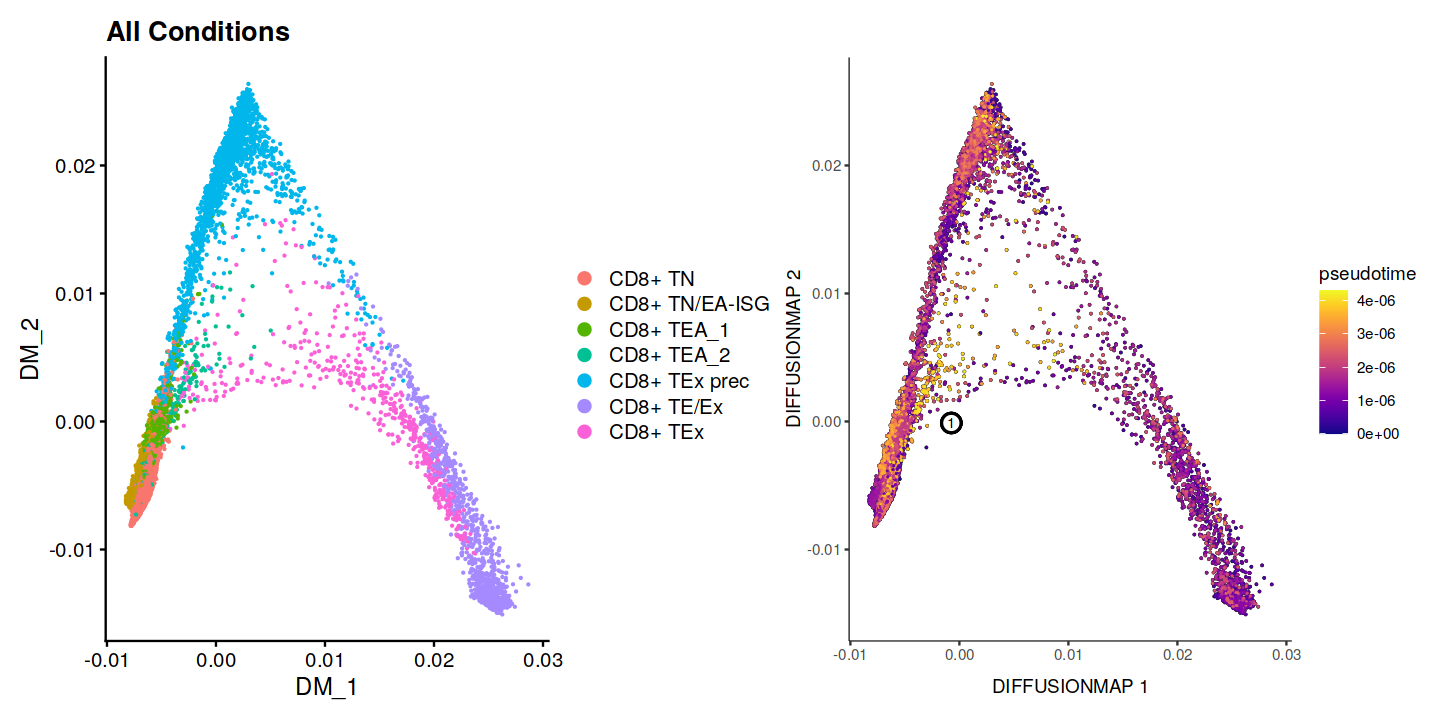

In [138]:
h_ = 6
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

g1A<-DimPlot(abc.cd8s.all, reduction = 'DiffusionMap') + ggtitle('All Conditions')
g1B<-plot_cells_(cds = abc.cd8s.all.cds, 
                reduction_method = 'DIFFUSIONMAP',
                color_cells_by = "pseudotime", show_trajectory_graph = TRUE, 
                   trajectory_graph_segment_size = 1, trajectory_graph_color = "black",
                   graph_label_size = 3,
              label_cell_groups=FALSE, label_roots = TRUE,
               label_leaves=TRUE,
               label_branch_points=TRUE)
g1<-g1A+g1B

# for (ext in c('.svg', '.png', '.pdf')){
#     fn<-paste0(data_path, 'figures/', 'cd8_trajectory_all', ext)
#     ggsave(fn, g1, height = h_, width = w_)}

g1

In [143]:
traj.plots<-list()
conditions <- unique(abc.cd8s.all.cds$orig.ident)
for (i in seq_along(conditions)){
    g1<-DimPlot(abc.cd8s.so[[i]], reduction = 'DiffusionMap') + ggtitle(paste0('Condition: ', conditions[[i]]))

    
    g2<-plot_cells_(cds = abc.cd8s.all.cds[, abc.cd8s.all.cds$orig.ident == conditions[[i]]], 
                    reduction_method = 'DIFFUSIONMAP', 
                   color_cells_by = "pseudotime", show_trajectory_graph = TRUE, 
                   trajectory_graph_segment_size = 1, trajectory_graph_color = "black",
                   graph_label_size = 3,
              label_cell_groups=FALSE, label_roots = TRUE,
               label_leaves=TRUE,
               label_branch_points=TRUE)
    g<-cowplot::plot_grid(g1, g2, ncol = 1)#g1 + g2
    traj.plots[[conditions[[i]]]]<-g
}

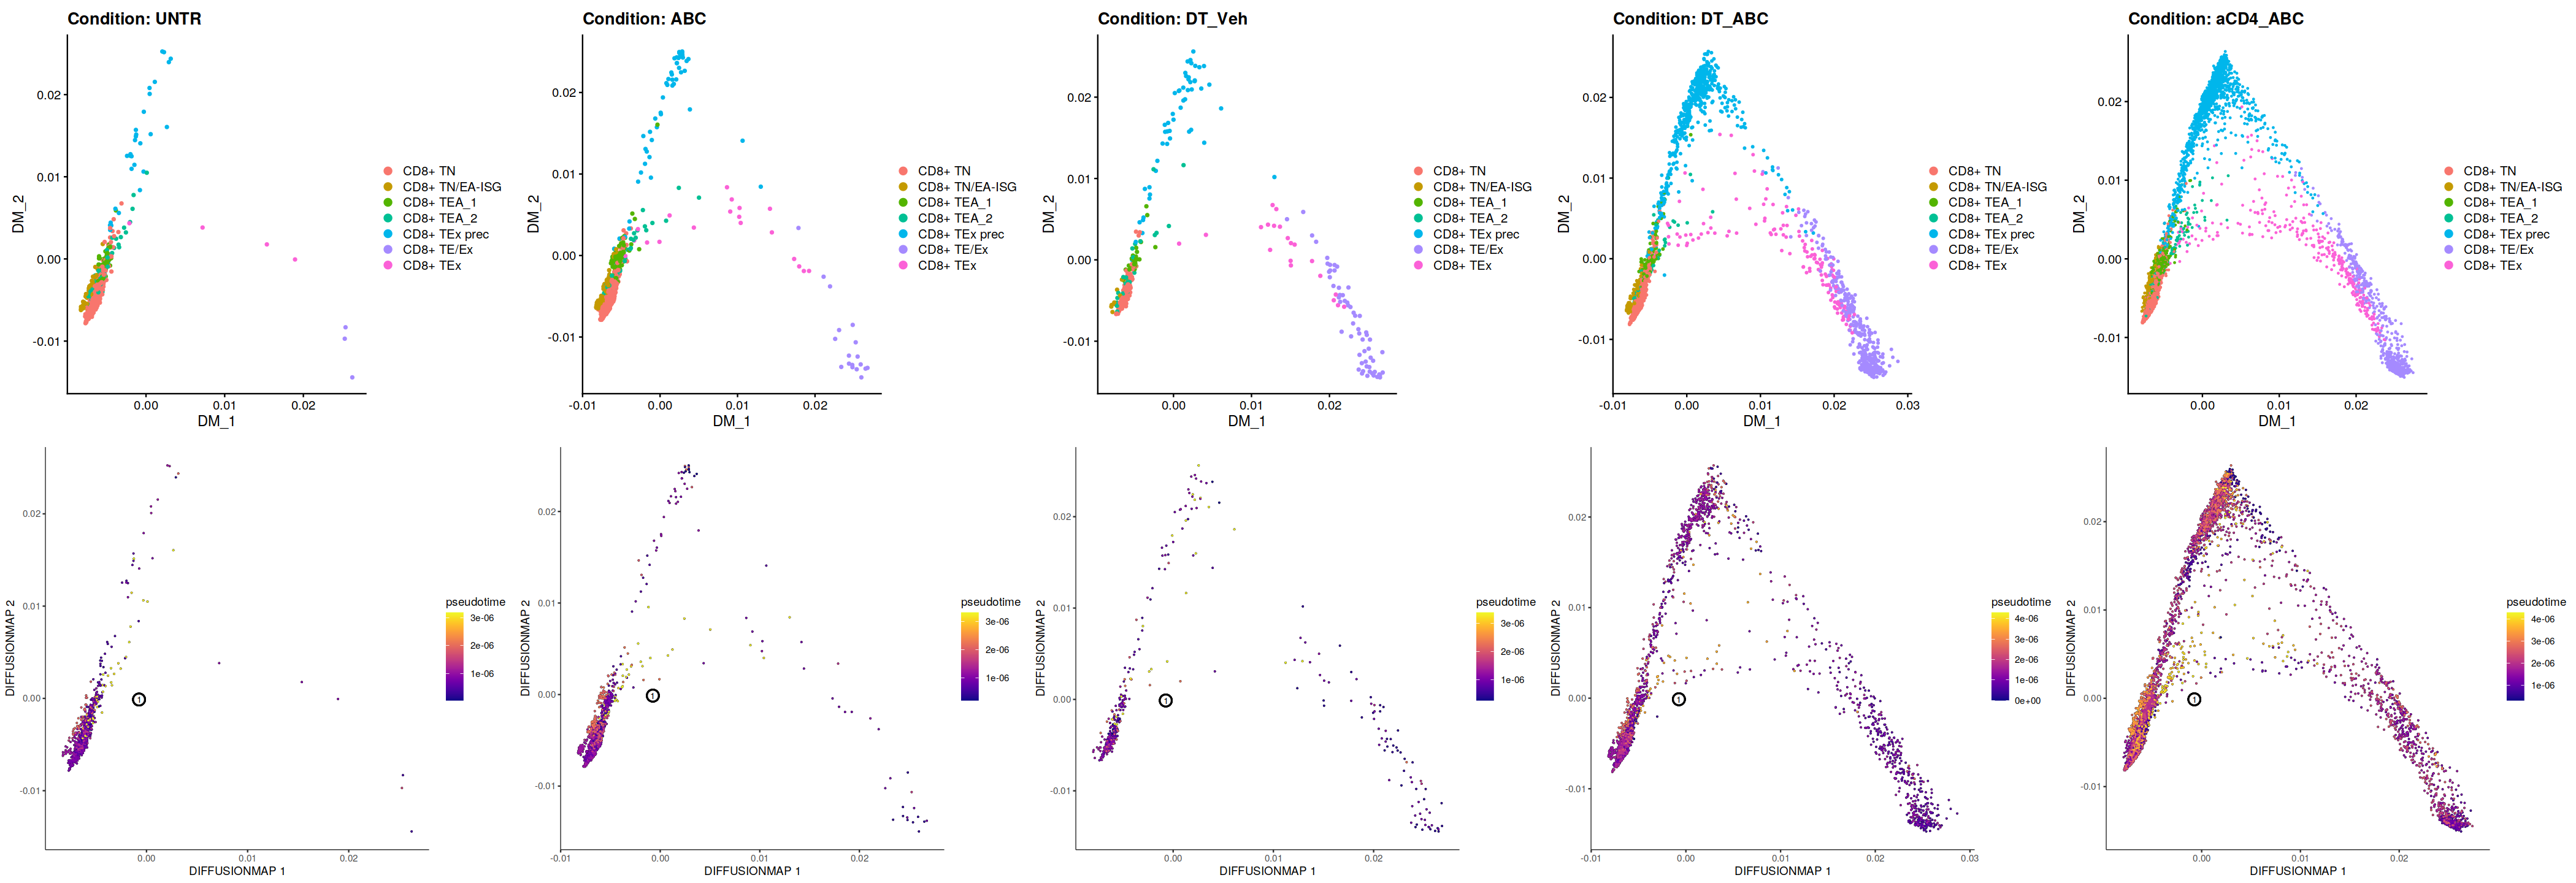

In [144]:
h_ = 12
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

g2<-cowplot::plot_grid(plotlist=traj.plots, ncol = length(traj.plots))


g2